# GNI Handwriting Baseline: Don/Doff Robustness Pipeline

This notebook sets up training, inference, and robustness evaluation for the handwriting task using the baseline model in the `generic-neuromotor-interface` repo.

**This notebook does:**
1. Environment & repo install (editable).
2. Data checks for your `handwriting_corpus.csv`.
3. Train baseline handwriting model (Hydra + PyTorch Lightning).
4. Locate checkpoint.
5. Post-hoc robustness evaluation: **channel rotation/permutation sweeps** to mimic don/doff misplacement.
6. Visualize results (CER vs. rotation/permutation).

> Tip: Run this notebook from a Python/conda env that satisfies `environment.yml` in the repo. GPU is recommended but not required.


In [25]:

# Prerequisites (run in your terminal once)
# conda env create -f path/to/repo/environment.yml
# conda activate gni
# pip install -e path/to/repo

import os, sys, subprocess, json, shutil
from pathlib import Path

# EDIT THESE PATHS IF YOU NEED
# repo root that contains 'config/', 'generic_neuromotor_interface/'
REPO_ROOT = Path.home() / "generic-neuromotor-interface"
# directory containing handwriting HDF5 files + handwriting_corpus.csv
DATA_DIR  = Path.home() / "emg_data"  
# Hydra logs (default from handwriting.yaml)
RUNS_DIR  = REPO_ROOT / "logs"
# directory containing pretrained models
PRETRAINED_DIR = Path.home() / "emg_models"

# choose mode: "pretrained" or "train"
MODE = "pretrained"

# training params (used only in MODE == "train")
MAX_EPOCHS = 10
SEED = 42
ACCEL = "gpu" # Lighting hardware
DEVICES = 1 # number of hardware in case you have more GPUs
if ACCEL == 'cpu':
    DEVICES = 1

# make repo importable for in-notebook training/eval
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

assert (DATA_DIR / "handwriting_corpus.csv").exists(), f"CSV not found: {DATA_DIR/'handwriting_corpus.csv'}"
print("Repo:", REPO_ROOT)
print("Data:", DATA_DIR)
print("Pretrained dir (expected):", PRETRAINED_DIR)
assert REPO_ROOT.exists(), f"Repo not found: {REPO_ROOT}"
assert (DATA_DIR / "handwriting_corpus.csv").exists(), f"CSV not found: {DATA_DIR/'handwriting_corpus.csv'}"


Repo: /home/hh/generic-neuromotor-interface
Data: /home/hh/emg_data
Pretrained dir (expected): /home/hh/emg_models


## Quick data check (counts per split / per user)

In [26]:

import pandas as pd

csv = pd.read_csv(DATA_DIR / "handwriting_corpus.csv")
csv.columns = [c.strip().lower() for c in csv.columns]

per_split = (csv.groupby(["split","user_number"])
               .agg(n_unique_datasets=("dataset_number","nunique"))
               .reset_index())

summary = (per_split.groupby("split")["n_unique_datasets"]
           .agg(["count","mean","min","max","median"])
           .rename(columns={"count":"users"}))

print(summary)
per_split.head(12)


       users    mean  min  max  median
split                                 
test      10   5.400    4    6     6.0
train     80   7.725    1   17     8.0
val       10  13.500    6   26     9.0


,split,user_number,n_unique_datasets
0,test,10,6
1,test,11,4
2,test,16,6
3,test,32,6
4,test,43,6
5,test,51,4
6,test,61,4
7,test,70,6
8,test,82,6
9,test,87,6


## Discover pretrained checkpoint (if using pretrained)

In [27]:

def find_pretrained_ckpt(root: Path) -> Path | None:
    cand1 = root / "handwriting" / "model_checkpoint.ckpt"
    if cand1.exists():
        return cand1
    ckp = root / "handwriting"
    if ckp.exists():
        ckpts = sorted(ckp.rglob("*.ckpt"))
        if ckpts:
            return ckpts[-1]
    return None

CKPT_PATH = None
if MODE == "pretrained":
    ck = find_pretrained_ckpt(PRETRAINED_DIR)
        
print("Detected CKPT_PATH:", CKPT_PATH)


Detected CKPT_PATH: None


## Handwriting Model architecture schematic and Live tensor shapes

This cell **shows the exact order** of operations for the handwriting model and prints **live tensor shapes** from one test batch:
**N=batch, T=time, C=channels, F=frequency, D=RotationInvariantMPFMLP output dim**
```
(raw EMG) (N, T, C)
    └─ permute → (N, C, T)
        └─ MPF featurizer (MultivariatePowerFrequencyFeatures)
            → (N, F, C, C, T)
            └─ SpecAug (MaskAug, optional)
                → (N, F, C, C, T)
                └─ RotationInvariantMPFMLP (mean over rotated channel views)
                    → (N, D, T)
                    └─ transpose → (N, T, D)
                        └─ Conformer encoder
                            → emissions: (N, T_down, vocab_size)
```
In Summary:
* Features: MPF features
* Architecture: rotation-invariance module → Conformer encoder (streaming/causal) → linear * projection → CTC loss/decoding
* Repo classes:
    * MultivariatePowerFrequencyFeatures (MPF)
    * RotationInvariantMPFMLP
    * HandwritingConformer + HandwritingArchitecture (wraps encoder + projection/CTC)
* The downloaded pretrained handwriting model points to these exact classes via its model_config.yaml 
```(e.g., _target_: generic_neuromotor_interface.networks.HandwritingArchitecture with HandwritingConformer and MPF featurizer)```

In [28]:
# check Handwriting architecture schematic and live tensor shape
import torch
from hydra.core.global_hydra import GlobalHydra
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from generic_neuromotor_interface.lightning import HandwritingModule

def _build_test_loader(repo_root: Path, data_dir: Path, batch_size: int = 2, num_workers: int = 2):
    # clear any previous Hydra state
    GlobalHydra.instance().clear()
    with initialize_config_dir(config_dir=str(repo_root / "config"), job_name="shape_probe", version_base="1.1"):
        cfg = compose(
            config_name="handwriting",
            overrides=[f"data_location={data_dir}", "train=False", "eval=False"],
        )
    dm = instantiate(cfg.data_module)
    dm.setup(stage="test")
    loader = dm.test_dataloader()
    return loader, cfg


loader, cfg = _build_test_loader(REPO_ROOT, DATA_DIR, batch_size=2, num_workers=2)
it = iter(loader)
try:
    batch = next(it)
except StopIteration:
    raise RuntimeError(
        "Test DataLoader is empty. Check DATA_DIR points to your HDF5 files."
    )

if 'CKPT_PATH' in globals() and CKPT_PATH is not None and Path(CKPT_PATH).exists():
    module = HandwritingModule.load_from_checkpoint(str(CKPT_PATH), map_location="cpu")
else:
    module = instantiate(cfg.lightning_module)

module.eval()
net = module.network
net.eval()

print("Handwriting pipeline (module.network)")
print(type(net).__name__)
for name in ["featurizer", "specaug", "rotation_invariant_mlp", "conformer"]:
    comp = getattr(net, name, None)
    if comp is not None:
        print(f" - {name}: {type(comp).__name__}")
print()

# take one batch and ensure (N, C, T)
batch = next(iter(loader))
x = batch["emg"]
print("batch['emg'] shape (raw):", tuple(x.shape))

B, D1, D2 = x.shape
expected_channels = None
for k in ["num_channels", "channels", "emg_channels"]:
    try:
        expected_channels = int(getattr(cfg.data_module, k))
        break
    except Exception:
        pass

def looks_like_channels(d):
    # device has 16 channels
    return d <= 32

def looks_like_time(d):
    # time dimension is usually much larger than channels
    return d >= 256

# Decide orientation
if expected_channels is not None:
    if D1 == expected_channels and D2 != expected_channels:
        orient = "(N,C,T) (kept)"
        x_ct = x
    elif D2 == expected_channels and D1 != expected_channels:
        orient = "(N,T,C) → permute to (N,C,T)"
        x_ct = x.permute(0, 2, 1)
    else:
        # fallback to heuristic
        if looks_like_channels(D1) and looks_like_time(D2):
            orient = "(N,C,T) (kept via heuristic)"
            x_ct = x
        elif looks_like_channels(D2) and looks_like_time(D1):
            orient = "(N,T,C) → permute to (N,C,T) (heuristic)"
            x_ct = x.permute(0, 2, 1)
        else:
            orient = "Ambiguous; assuming (N,C,T)"
            x_ct = x
else:
    # no config hint; use heuristic
    if looks_like_channels(D1) and looks_like_time(D2):
        orient = "(N,C,T) (kept via heuristic)"
        x_ct = x
    elif looks_like_channels(D2) and looks_like_time(D1):
        orient = "(N,T,C) → permute to (N,C,T) (heuristic)"
        x_ct = x.permute(0, 2, 1)
    else:
        orient = "Ambiguous; assuming (N,C,T)"
        x_ct = x

print("orientation decision:", orient)
print("to (N,C,T) shape:", tuple(x_ct.shape))

with torch.no_grad():
    mpf = net.featurizer(x_ct)
print("after MPF:", tuple(mpf.shape), "(N, F, C, C, T)")

# SpecAug (if present)
if hasattr(net, "specaug") and net.specaug is not None:
    with torch.no_grad():
        aug = net.specaug(mpf)
    print("after SpecAug:", tuple(aug.shape))
else:
    aug = mpf
    print("SpecAug:", "None (skipped)")

with torch.no_grad():
    ri = net.rotation_invariant_mlp(aug)
print("after RotationInv:", tuple(ri.shape), "(N, D, T)")

enc_in = ri.transpose(-1, -2)
print("to Conformer:", tuple(enc_in.shape), "(N, T, D)")

with torch.no_grad():
    emissions = net.conformer(enc_in)
print("emissions:", tuple(emissions.shape), "(N, T_down, vocab)")
slc = getattr(net, "slice", None)
if slc is not None:
    print("time slice:", slc)


[setup] Loading datasets for split test: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]
/home/hh/miniconda3/envs/neuromotor/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.


Handwriting pipeline (module.network)
HandwritingArchitecture
 - featurizer: MultivariatePowerFrequencyFeatures
 - specaug: MaskAug
 - rotation_invariant_mlp: RotationInvariantMPFMLP
 - conformer: SlicedSequential

batch['emg'] shape (raw): (1, 16, 66728)
orientation decision: (N,C,T) (kept via heuristic)
to (N,C,T) shape: (1, 16, 66728)
after MPF: (1, 6, 16, 16, 1663) (N, F, C, C, T)
after SpecAug: (1, 6, 16, 16, 1663)
after RotationInv: (1, 64, 1663) (N, D, T)
to Conformer: (1, 1663, 64) (N, T, D)
emissions: (1, 147, 100) (N, T_down, vocab)
time slice: slice(491, -1, 8)


## Train baseline (optional; only if MODE == 'train')

In [7]:

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
pl.seed_everything(SEED, workers=True)

# epoch-level CSV metric logger
class CSVMetricLogger(Callback):
    def __init__(self, out_csv: Path):
        super().__init__()
        self.out_csv = Path(out_csv)
        self.out_csv.parent.mkdir(parents=True, exist_ok=True)
        self._header_written = False

    def _write_row(self, row: dict):
        keys = sorted(row.keys())
        write_header = (not self.out_csv.exists()) or (not self._header_written)
        with self.out_csv.open("a", newline="") as f:
            w = csv.DictWriter(f, fieldnames=keys)
            if write_header:
                w.writeheader()
                self._header_written = True
            w.writerow(row)

    def on_train_epoch_end(self, trainer, pl_module):
        m = trainer.callback_metrics
        row = {"stage": "train", "epoch": int(trainer.current_epoch)}
        for k, v in m.items():
            if k.startswith("train_") or "loss" in k or "character_error_rate" in k:
                try:
                    row[k] = float(v.cpu().item() if hasattr(v, "cpu") else float(v))
                except Exception:
                    continue
        self._write_row(row)

    def on_validation_epoch_end(self, trainer, pl_module):
        m = trainer.callback_metrics
        row = {"stage": "val", "epoch": int(trainer.current_epoch)}
        for k, v in m.items():
            if k.startswith("val_") or "loss" in k or "character_error_rate" in k:
                try:
                    row[k] = float(v.cpu().item() if hasattr(v, "cpu") else float(v))
                except Exception:
                    continue
        self._write_row(row)

# run training in-process to attach our CSV callback
TRAIN_LOG_DIR = REPO_ROOT / "logs" / "csv_curves"
CURVES_CSV = TRAIN_LOG_DIR / "handwriting_curves.csv"

if MODE == "train":
    with initialize(config_path=str(REPO_ROOT/"config"), version_base="1.1"):
        cfg = compose(
            config_name="handwriting",
            overrides=[
                f"data_location={DATA_DIR}",
                f"seed={SEED}",
                "train=True",
                "eval=True",
                f"trainer.max_epochs={MAX_EPOCHS}",
                f"trainer.accelerator={ACCEL}",
                f"trainer.devices={DEVICES}",
            ],
        )
    print(OmegaConf.to_yaml(cfg))

    # instantiate module & datamodule
    module = instantiate(cfg.lightning_module, _convert_="all")
    datamodule = instantiate(cfg.data_module, _convert_="all")
    datamodule.setup(stage="fit")

    # build trainer (keep default logger and add CSV callback)
    trainer = pl.Trainer(
        accelerator=ACCEL,
        devices=DEVICES,
        max_epochs=MAX_EPOCHS,
        callbacks=[CSVMetricLogger(CURVES_CSV)],
    )
    trainer.fit(module, datamodule=datamodule)

    # after fit, try to get the best checkpoint path if ModelCheckpoint used
    best_ckpt = None
    for cb in trainer.callbacks:
        if hasattr(cb, "best_model_path"):
            best_ckpt = cb.best_model_path or None
    CKPT_PATH = Path(best_ckpt) if best_ckpt else None
    print("Training complete. Best checkpoint:", CKPT_PATH)
else:
    print("MODE != 'train' — skipping training")


Seed set to 42


MODE != 'train' — skipping training


## Plot training/validation curves (CER & Loss)

In [8]:

import pandas as pd
import matplotlib.pyplot as plt

curves_path = CURVES_CSV if (MODE=="train") else (REPO_ROOT / "logs" / "csv_curves" / "handwriting_curves.csv")
if curves_path.exists():
    dfc = pd.read_csv(curves_path)
    display(dfc.tail())

    def plot_curve(metric_key: str, title: str):
        plt.figure()
        for stage in ["train","val"]:
            sub = dfc[dfc["stage"]==stage]
            if metric_key in sub:
                plt.plot(sub["epoch"], sub[metric_key], marker="o", label=stage)
        plt.xlabel("epoch"); plt.ylabel(metric_key); plt.title(title); plt.legend(); plt.grid(True); plt.show()

    # Common names used in module logging:
    # try keys like 'train_loss', 'val_loss', 'train_character_error_rate', 'val_character_error_rate'
    for key, title in [
        ("train_loss", "Loss (train/val)"), ("val_loss","Loss (train/val)"),
        ("train_character_error_rate","CER (train/val)"),
        ("val_character_error_rate","CER (train/val)"),
    ]:
        if key in dfc.columns:
            plot_curve(key, title)
else:
    print("No curves CSV found yet at:", curves_path)


No curves CSV found yet at: /home/hh/generic-neuromotor-interface/logs/csv_curves/handwriting_curves.csv


## Robustness evaluation utils

In [ ]:
from typing import Iterable
from hydra.utils import instantiate
from hydra import initialize, initialize_config_dir, compose
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
import json, torch
import pytorch_lightning as pl

def build_test_loader(repo_root: Path, data_dir: Path, batch_size: int | None = None, num_workers: int | None = None):
    # Use relative config_path="config" by chdir into the repo
    cwd = os.getcwd()
    try:
        GlobalHydra.instance().clear()
        os.chdir(str(repo_root))
        with initialize(config_path="config", job_name="rot_sweep", version_base="1.1"):
            cfg = compose(
                config_name="handwriting",
                overrides=[
                    f"data_location={data_dir}",
                    "train=False",
                    "eval=False",
                ],
            )
        if batch_size is not None:
            cfg.data_module.batch_size = batch_size
        if num_workers is not None:
            cfg.data_module.num_workers = num_workers

        dm = instantiate(cfg.data_module)
        dm.setup(stage="test")
        loader = dm.test_dataloader()
        return loader, cfg
    finally:
        os.chdir(cwd)

def load_handwriting_module(ckpt_path: Path | None, repo_root: Path = None, data_dir: Path = None, device: str = "cpu"):
    if ckpt_path is not None and Path(ckpt_path).exists():
        module = HandwritingModule.load_from_checkpoint(str(ckpt_path), map_location=device)
    else:
        # compose from config when no checkpoint
        cwd = os.getcwd()
        try:
            assert repo_root is not None and data_dir is not None, "repo_root and data_dir required if ckpt_path is None"
            GlobalHydra.instance().clear()
            os.chdir(str(repo_root))
            with initialize(config_path="config", job_name="rot_module", version_base="1.1"):
                cfg = compose(config_name="handwriting", overrides=[f"data_location={data_dir}"])
            module = instantiate(cfg.lightning_module)
            module.to(device)
        finally:
            os.chdir(cwd)
    module.eval()
    return module

def make_rotated_loader(base_loader: DataLoader, k: int) -> DataLoader:
    dataset = base_loader.dataset
    collate = base_loader.collate_fn
    bs = base_loader.batch_size
    nw = base_loader.num_workers
    pm = getattr(base_loader, "pin_memory", False)

    def rotated_collate(items):
        b = collate(items)
        # In this repo, EMG is (N, T, C) when it reaches the model;
        # rotate along channel dim (-1) to simulate don/doff ring rotation.
        b["emg"] = torch.roll(b["emg"], shifts=int(k), dims=-1)
        return b

    return DataLoader(
        dataset,
        batch_size=bs,
        shuffle=False,
        num_workers=nw,
        pin_memory=pm,
        collate_fn=rotated_collate,
    )

def _as_float(v):
    import torch
    if isinstance(v, torch.Tensor):
        return float(v.detach().cpu().item())
    try:
        return float(v)
    except Exception:
        return float("nan")

def extract_first_match(d: dict, candidates: list[str]):
    for k in candidates:
        if k in d:
            return _as_float(d[k])
    return float("nan")

def rotation_sweep_with_trainer(module, base_loader: DataLoader, rotations, device="cpu", max_batches=None):
    trainer = pl.Trainer(
        accelerator=("gpu" if (device == "cuda" and torch.cuda.is_available()) else "cpu"),
        devices=1,
        logger=False,
        enable_checkpointing=False,
        enable_progress_bar=False,
        limit_test_batches=max_batches if max_batches is not None else 1.0,
    )

    results = {}
    printed_keys = False
    for k in rotations:
        rot_loader = make_rotated_loader(base_loader, k)
        out = trainer.test(module, dataloaders=rot_loader, verbose=False)  # list[dict]
        metrics = out[0] if out else {}

        if not printed_keys:
            print("[metric keys]", sorted(metrics.keys()))
            printed_keys = True

        cer = extract_first_match(metrics, [
            "test/CER",               # <-- YOUR MODULE'S KEY
            "CER",
            "test/cer", "cer",
            "test/character_error_rate", "character_error_rate",
            "test_character_error_rate",
        ])

        results[int(k)] = {"cer": cer, "n": len(rot_loader.dataset)}
    return results

def plot_rotation_curve(results: dict[int, dict[str, float]]):
    import matplotlib.pyplot as plt
    ks = sorted(results.keys())
    cer = [results[k]["cer"] for k in ks]
    plt.figure()
    plt.plot(ks, cer, marker="o")
    plt.xlabel("Channel rotation (k)")
    plt.ylabel("CER")
    plt.title("CER vs. Channel Rotation (handwriting baseline)")
    plt.grid(True)
    plt.show()


## Run rotation sweep (don/doff proxy)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


one-shot test metrics: {'test_loss': 106.22371673583984, 'test/CER': 120.0, 'test/IER': 0.0, 'test/DER': 20.0, 'test/SER': 100.0}


[setup] Loading datasets for split test: 100%|██████████| 54/54 [00:05<00:00, 10.29it/s]
/home/hh/miniconda3/envs/neuromotor/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[metric keys] ['test/CER', 'test/DER', 'test/IER', 'test/SER', 'test_loss']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results: {
  "-8": {
    "cer": 147.40260314941406,
    "n": 6419
  },
  "-7": {
    "cer": 147.40260314941406,
    "n": 6419
  },
  "-6": {
    "cer": 147.40260314941406,
    "n": 6419
  },
  "-5": {
    "cer": 147.40260314941406,
    "n": 6419
  },
  "-4": {
    "cer": 149.35064697265625,
    "n": 6419
  },
  "-3": {
    "cer": 150.64935302734375,
    "n": 6419
  },
  "-2": {
    "cer": 150.64935302734375,
    "n": 6419
  },
  "-1": {
    "cer": 150.64935302734375,
    "n": 6419
  },
  "0": {
    "cer": 149.35064697265625,
    "n": 6419
  },
  "1": {
    "cer": 151.2987060546875,
    "n": 6419
  },
  "2": {
    "cer": 152.59739685058594,
    "n": 6419
  },
  "3": {
    "cer": 151.2987060546875,
    "n": 6419
  },
  "4": {
    "cer": 150.0,
    "n": 6419
  },
  "5": {
    "cer": 148.7012939453125,
    "n": 6419
  },
  "6": {
    "cer": 148.05194091796875,
    "n": 6419
  },
  "7": {
    "cer": 146.7532501220703,
    "n": 6419
  },
  "8": {
    "cer": 146.7532501220703,
    "n": 6419
 

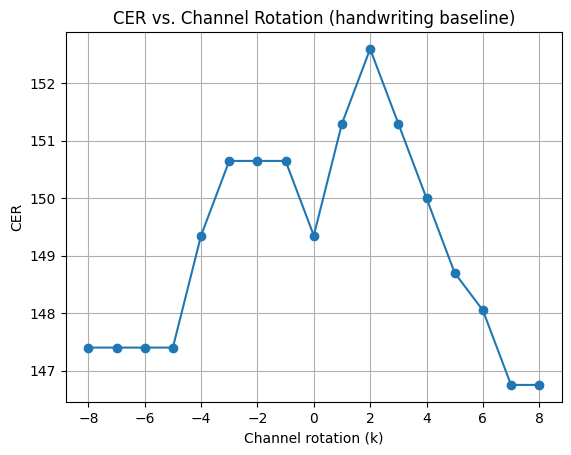

In [ ]:


trainer = pl.Trainer(
    accelerator=("gpu" if torch.cuda.is_available() else "cpu"),
    devices=1,
    logger=False,
    enable_checkpointing=False,
    enable_progress_bar=False,
    limit_test_batches=10,  # quick smoke test
)

out = trainer.test(module, dataloaders=loader, verbose=False)
print("one-shot test metrics:", out[0])  # should include 'test/CER' as a float

device = "cuda" if torch.cuda.is_available() else "cpu"
loader, cfg = build_test_loader(REPO_ROOT, DATA_DIR, batch_size=8, num_workers=4)
module = load_handwriting_module(CKPT_PATH, repo_root=REPO_ROOT, data_dir=DATA_DIR, device=device)
module.to(device)

# Infer channel count robustly from a sample batch
first_batch = next(iter(loader))
emg = first_batch["emg"]
C = int(emg.shape[-1] if emg.shape[-1] <= 256 else emg.shape[1])

step = max(1, C // 16)
half = max(1, C // 2)
rotations = list(range(-half, half + 1, step))

results = rotation_sweep_with_trainer(module, loader, rotations, device=device, max_batches=50)
print("Results:", json.dumps(results, indent=2))
plot_rotation_curve(results)


## [Optional] Random permutation stress DEBUG

In [ ]:
def permute_channels(x: torch.Tensor, perm: torch.Tensor) -> torch.Tensor:
    # x: (N, T, C). apply a channel permutation given by an index tensor 'perm' of size C.
    return x.index_select(dim=-1, index=perm.to(x.device))

@torch.no_grad()
def eval_random_permutation(module: HandwritingModule, loader, trials: int = 5, max_batches: int | None = None, device="cpu"):
    import numpy as np
    all_scores = []
    for t in range(trials):
        # Reset metrics
        if hasattr(module, "metrics") and "test_metrics" in module.metrics:
            module.metrics["test_metrics"].reset()
        n_items = 0
        perm = None
        for b_idx, batch in enumerate(loader):
            if max_batches is not None and b_idx >= max_batches:
                break
            x = batch["emg"]  # (N, T, C)
            if perm is None:
                C = x.shape[-1]
                perm = torch.as_tensor(np.random.permutation(C), dtype=torch.long)
            x = permute_channels(x, perm)
            batch = {**batch, "emg": x.to(device), "emg_lengths": batch["emg_lengths"].to(device), "prompts": batch["prompts"].to(device), "prompt_lengths": batch["prompt_lengths"].to(device)}
            module.test_step(batch, b_idx)
            n_items += int(x.shape[0])
        cer = float("nan")
        if hasattr(module, "metrics") and "test_metrics" in module.metrics:
            m = module.metrics["test_metrics"].compute()
            for key in ["test_character_error_rate", "character_error_rate", "cer"]:
                if key in m:
                    try:
                        cer = float(m[key])
                        break
                    except Exception:
                        pass
        all_scores.append(cer)
    return all_scores

perm_cers = eval_random_permutation(module, loader, trials=5, max_batches=50, device=device)
print("CER under random permutations (5 trials):", perm_cers)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1, len(perm_cers)+1), perm_cers, marker="o")
plt.xlabel("Trial")
plt.ylabel("CER")
plt.title("CER under random channel permutations")
plt.grid(True)
plt.show()


NameError: name 'torch' is not defined

## [Optional] Save results to CSV

In [ ]:

import pandas as pd
out_dir = REPO_ROOT / "logs" / ("robust_eval_train" if MODE=="train" else "robust_eval_pretrained")
out_dir.mkdir(parents=True, exist_ok=True)

# Rotation sweep
rot_df = pd.DataFrame([{"rotation": k, **v} for k, v in results.items()]).sort_values("rotation")
rot_df.to_csv(out_dir / "rotation_sweep.csv", index=False)

# Random permutation
perm_df = pd.DataFrame({"trial": list(range(1, len(perm_cers)+1)), "cer": perm_cers})
perm_df.to_csv(out_dir / "permutation_trials.csv", index=False)

print("Saved to:", out_dir)
